In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv("~/Documents/csp/data2.csv")
df.shape

(7613, 7)

In [3]:
df.head(5)

,n,subtree_cnt,depth,height,loexpect,hiexpect,rnd
0,9,2,4,1,3.767442,5.232558,4.0
1,9,1,5,0,4.302326,4.697674,4.0
2,9,6,1,4,7.395349,1.604651,4.0
3,9,4,2,3,2.534884,6.465116,4.0
4,9,1,2,0,2.534884,6.465116,4.0


In [4]:
df['alt'] = df.apply(axis=1,
    func = lambda x: x.hiexpect if x.depth % 2 else x.loexpect)
df.head(15)

,n,subtree_cnt,depth,height,loexpect,hiexpect,rnd,alt
0,9,2,4,1,3.767442,5.232558,4.0,3.767442
1,9,1,5,0,4.302326,4.697674,4.0,4.697674
2,9,6,1,4,7.395349,1.604651,4.0,1.604651
3,9,4,2,3,2.534884,6.465116,4.0,2.534884
4,9,1,2,0,2.534884,6.465116,4.0,2.534884
5,9,3,3,2,3.883721,5.116279,4.0,5.116279
6,9,1,1,0,5.790698,3.209302,4.0,3.209302
7,9,1,1,0,5.790698,3.209302,4.0,3.209302
8,14,6,1,2,11.251642,2.748358,6.5,2.748358
9,14,3,2,1,4.313477,9.686523,6.5,4.313477


In [5]:
y = df.apply(axis=1, func = lambda x: x.alt < x.rnd)
#y.value_counts().plot(kind="bar");
y.value_counts()

True     5649
False    1964
dtype: int64

In [6]:
df['isleaf'] = df.apply(axis=1, func = lambda x: x.height == 0)
df.head(5)

,n,subtree_cnt,depth,height,loexpect,hiexpect,rnd,alt,isleaf
0,9,2,4,1,3.767442,5.232558,4.0,3.767442,False
1,9,1,5,0,4.302326,4.697674,4.0,4.697674,True
2,9,6,1,4,7.395349,1.604651,4.0,1.604651,False
3,9,4,2,3,2.534884,6.465116,4.0,2.534884,False
4,9,1,2,0,2.534884,6.465116,4.0,2.534884,True


In [40]:
X = pd.DataFrame([df.n, df.subtree_cnt,
    df.depth, df.height, df.isleaf]).transpose()
X['depth'] = df.depth.apply(lambda x: np.power(x, 1.7))
X['height'] = df.height.apply(lambda x: np.power(x, 1.2))
# TODO
X.shape

(7613, 5)

In [41]:
X.head(5)

,n,subtree_cnt,depth,height,isleaf
0,9,2,10.556063,1.000000,0
1,9,1,15.425847,0.000000,1
2,9,6,1.000000,5.278032,0
3,9,4,3.249010,3.737193,0
4,9,1,3.249010,0.000000,1


In [42]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=525)
model = LogisticRegression().fit(X_train, y_train)

print("train score:", model.score(X_train, y_train))
print("test score:", model.score(X_test, y_test))

train score: 0.7863023296549309
test score: 0.7872899159663865


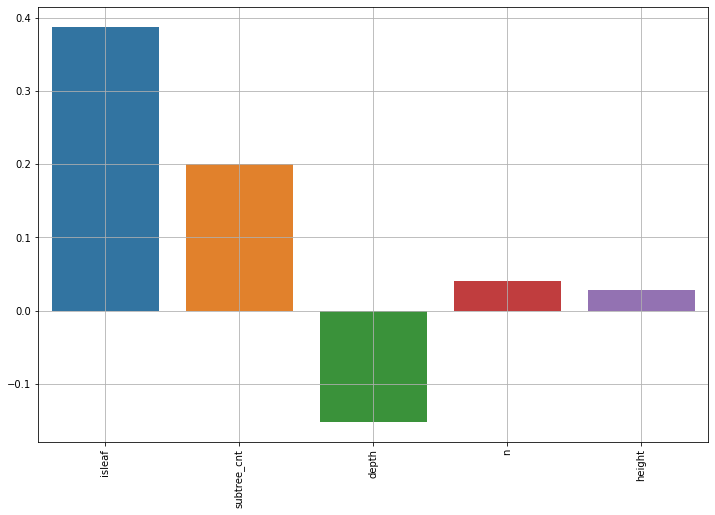

In [43]:
def logistic_regression_features(X, model, top=-1):
    indices = np.argsort(np.absolute(model.coef_[0]))[::-1][:top]
    plt.figure(figsize=(12,8))
    barplot = sns.barplot(x=X.columns[indices], y=model.coef_[0][indices], orient='vertical')
    plt.setp(barplot.get_xticklabels(), rotation=90)
    plt.grid(True)
    
logistic_regression_features(X, model, top=20)

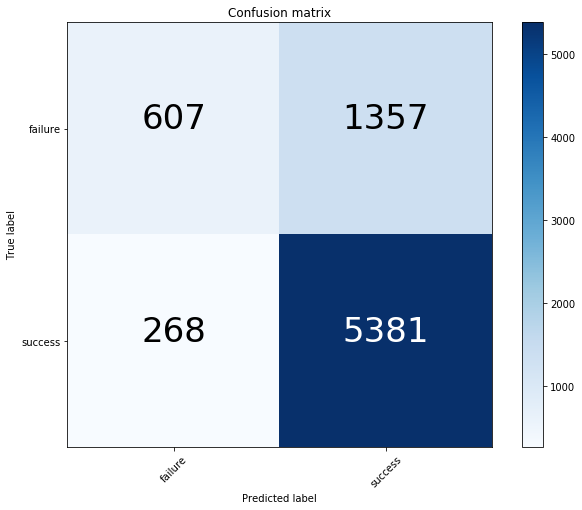

In [50]:
import itertools
from sklearn.metrics import confusion_matrix, accuracy_score

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figsize=(9, 7)):
    matrix = confusion_matrix(y_true, y_pred)

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 size=int((figsize[0] / 10) * 38),
                 color="white" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plot_confusion_matrix(y, model.predict(X), classes=['failure', 'success'])

In [63]:
X_anal = pd.DataFrame([model.predict(X), y]).transpose()
X_anal = X_anal.rename(columns={0: 'predict', 1: 'expected'})
X_anal = pd.concat([df, X_anal], axis=1)
X_anal.head(20)
#X_anal.shape

X_anal = X_anal[X_anal.predict != X_anal.expected]

bv = (np.abs(X_anal.alt-X_anal.rnd) / X_anal.rnd) > 0.1
X_anal = X_anal[bv]

X_anal.head(5)

,n,subtree_cnt,depth,height,loexpect,hiexpect,rnd,alt,isleaf,predict,expected
5,9,3,3,2,3.883721,5.116279,4.0,5.116279,False,True,False
11,14,1,3,0,6.511333,7.488667,6.5,7.488667,True,True,False
12,14,1,3,0,6.511333,7.488667,6.5,7.488667,True,True,False
17,14,2,3,1,6.545650,7.454350,6.5,7.454350,False,True,False
20,14,1,3,0,6.503284,7.496716,6.5,7.496716,True,True,False


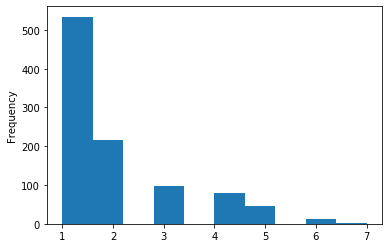

In [64]:
X_anal.subtree_cnt.plot(kind="hist");

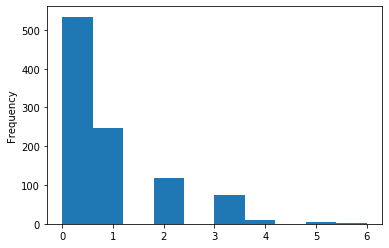

In [65]:
X_anal.height.plot(kind="hist");

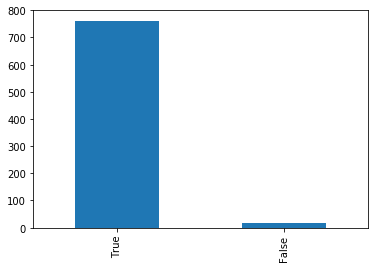

In [68]:
#X_anal[X_anal.height < 2].predict.value_counts().plot(kind="bar");

In [69]:
model.coef_

array([[ 0.04084652,  0.19990886, -0.15217468,  0.02842288,  0.38765058]])